## Introduction to global ocean biogeochemical modelling with transport operators
To model marine biogeochemical processes on a global scale we need to be able to account for the movement of chemical constituents both horizontally and vertically. We do this with a <b><i>tracer transport operator</i></b>.  When this operator acts on a tracer field it produces the advective-diffusive divergence of the tracer.

In order to represent the transport operator on a computer we have to discretize the tracer concentration field and the operator.  Once discretized the tracer field is represented as a vector and the operator is represented as a sparse matrix. (A sparse matrix behaves the same way as a regular matrix. The only difference is that in a sparse matrix the majority of the entries are zeros. These zeros are not stored explicitly to save computer memory making it possible to deal with fairly high resolution ocean models. 

Mathematically, the discretization converts an expression with partial derivatives into a matrix vector product:

$$\nabla \cdot \left[\mathbf{u}-\mathbf{K}\cdot\nabla \right]C \longrightarrow \mathbf{T}\mathbf{c}$$

where $\mathbf{T}$ is the flux divergence transport matrix and $\mathbf{c}$ is the tracer concentration vector. 

One can go a long way towards understanding what a tracer transport operator is by playing with a simple box model. We therefore introuce a simple box model before moving on to the <i>Ocean Circulation Inverse Model</i> (OCIM).


The simple box model we consider is embeded in a $2\times2\times2$ "shoebox". It has 5 <i>wet</i> boxes and 3 <i>dry</i> boxes.
<img src="boxmodel.png" width =800>

In [1]:
a = 6367e3   # Earth radius           (m)
A = 4*pi*a^2 # Earth surface area     (m²)
d = 3700     # ocean depth            (m)
V = 0.75*A*d # volume of ocean        (m³)
h = 200      # thickness of top layer (m)

dz = [h*ones(4,1);(d-h)*ones(4,1)] # grid box thicknesses       (m)
dV = (dz/d).*((V/4)*ones(8,1))     # grid box volumes           (m³)
dAz = dV./dz                       # area of face ⟂ to z axis   (m²)
dy = sqrt.(dAz)                    # north-south side length    (m)
dx = sqrt.(dAz)                    # east-west side length      (m)
dAx = dV./dy                       # area of face ⟂ to x axis   (m²)
dAy = dV./dx                       # area of face ⟂ to y axis   (m²)

msk = [1, 1, 1, 0, 1, 1, 0, 0]     # wet-dry mask wet=1 dry = 0 
iwet = findall(x -> x == 1, msk)        # index to wet gridboxes
idry = findall(x -> x == 0, msk)        # index to dry gridboxes
srf = [1, 1, 1, 0, 0]              # surface mask srface=1 bottom = 0
isrf = findall(x -> x == 1, srf) ;

The circulation consists of 
<ul>
    <li>a meridional overturning circulation flowing from box 1 to box 2 to box 6 to box 5 and back to box 1</li>
    <li>a zonal current in a reentrant channel from box 1 to box 3 and back to box 1</li>
    <li>vertical mixing representing deep convection between box 2 and box 6</li>
</ul>
    

In [2]:
using LinearAlgebra
using SparseArrays
TRdiv = spzeros(8,8)
# "Antarctic Circumpoloar Current" flow out minus flow in 
acc = 100e6  # (m³/s)
TRdiv += sparse([1,1],[1,3],dV[1]\[acc,-acc],8,8)
TRdiv += sparse([3,3],[3,1],dV[3]\[acc,-acc],8,8)
# "Meridional Overturning Circulation" flow out minus flow in
moc = 15e6    # (m³/s)
TRdiv += sparse([1,1],[1,5],dV[1]\[moc,-moc],8,8)
TRdiv += sparse([2,2],[2,1],dV[2]\[moc,-moc],8,8)
TRdiv += sparse([5,5],[5,6],dV[5]\[moc,-moc],8,8)
TRdiv += sparse([6,6],[6,2],dV[6]\[moc,-moc],8,8)
# vertical mixing at "high northern latitudes" flow out minus flow in
q = 10e6      # (m³/s)
TRdiv += sparse([2,2],[2,6],dV[2]\[q,-q],8,8)
TRdiv += sparse([6,6],[6,2],dV[6]\[q,-q],8,8)
TRdiv = TRdiv[iwet,iwet]
Matrix(TRdiv)

5×5 Array{Float64,2}:
  6.01987e-9   0.0         -5.23467e-9  -7.852e-10     0.0        
 -7.852e-10    1.30867e-9   0.0          0.0          -5.23467e-10
 -5.23467e-9   0.0          5.23467e-9   0.0           0.0        
  0.0          0.0          0.0          4.48686e-11  -4.48686e-11
  0.0         -7.4781e-11   0.0          0.0           7.4781e-11 

## An idealized radiocarbon simulation
Radiocarbon, <sup>14</sup>C, is produced by cosmic rays in the lower stratosphere and upper troposphere. It quickly reacts with oxygen to produce <sup>14</sup>CO<sub>2</sub>, which is then mixed throughout the troposphere and enters the ocean through air-sea gas exchange. Because the halflife of radiocarbon is only 5730 years a significant amount of deday can occur before the dissolved inorganic radiocarbon (DI<sup>14</sup>C) can mix uniformally throughout the ocean. As such the <sup>14</sup>C serves as a tracer label for water that was recently in contact with the atmosphere. 

Here we will perform an idealized radiocarbon simulation in our model. In this model we prescribe the atmospheric concentration to 1 and model the air-sea gas exchange using a constant piston velocity of $\kappa = $50m/10years. For the radioactive decay we use a timescale of $\tau =$(5730 years)/$\log(2)$.

In [3]:
sec_per_year = 365*24*60*60; 
κ = 50/(10*sec_per_year)     # m/s
τ = 5730*sec_per_year/log(2); # 1/s

In [4]:
M = TRdiv
M += κ*spdiagm(0 => srf)/h    # air-sea loss operator
M += spdiagm(0 => ones(5))/τ  # radioactive decay loss operator
s = -κ*srf/h;                 # air-sea source rate

In [5]:
R = - M\s;

In [6]:
age = -τ*log.(R)/sec_per_year

5-element Array{Float64,1}:
  514.4739601933616 
  404.49230963416727
  450.2111619689796 
 1496.145482003646  
  818.0106092795778 

## An idealized simulation of a radioactive tracer with an atmospheric origin usig OCIM

In [7]:
using AIBECS
t = empty_parameter_table()               # initialize table of parameters
add_parameter!(t, :τ, 5730u"yr" / log(2)) # add the radioactive decay e-folding timescale
add_parameter!(t, :κ, 50u"m" / 10u"yr")
initialize_Parameters_type(t)             # Generate the parameter table

┌ Warning: Error requiring Unitful from Flatten:
│ ArgumentError: Package Flatten does not have Unitful in its dependencies:
│ - If you have Flatten checked out for development and have
│   added Unitful as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Flatten
│ Stacktrace:
│  [1] require(::Module, ::Symbol) at ./loading.jl:836
│  [2] top-level scope at /Users/fprimeau/.julia/packages/Flatten/AXBiq/src/Flatten.jl:21
│  [3] eval at ./boot.jl:328 [inlined]
│  [4] eval at /Users/fprimeau/.julia/packages/Flatten/AXBiq/src/Flatten.jl:1 [inlined]
│  [5] (::getfield(Flatten, Symbol("##3#6")))() at /Users/fprimeau/.julia/packages/Requires/9Jse8/src/require.jl:67
│  [6] err(::getfield(Flatten, Symbol("##3#6")), ::Module, ::String) at /Users/fprimeau/.julia/packages/Requires/9Jse8/src/require.jl:38
│  [7] #2 at /Users/fprimeau/.julia/packages/Requires/9Jse8/src/require.jl:66 [inlined]
│  [8] 

In [8]:
t

,symbol,value,unit,printunit,mean_obs,variance_obs,optimizable,description
,Symbol,Float64,Unitful…,Unitful…,Float64,Float64,Bool,String
1,τ,2.60875e11,s,yr,NaN,NaN,false,
2,κ,1.5844e-7,m s^-1,m yr^-1,NaN,NaN,false,


In [9]:
# I added this cell for you to see how it prints nicely with the "print" units
# The table `t` prints the value in the SI units, 
# while the parameter p₀ prints in the units you used to create it
p₀

     τ = 8.27e+03 [yr] (fixed)
     κ = 5.00e+00 [m yr⁻¹] (fixed)


AIBECS.Parameters{Float64}


In [10]:
const mask, grd, T_OCIM = OCIM1.load() ;
T_14c(p) = T_OCIM
iwet = findall(x -> x == 1, vec(mask));  # index to wet gridboxes

Loading OCIM1 with JLD2 ✅


In [11]:
dz1 = grd["dzt"][1]               # thickness of the top layer
z = vec(grd["ZT3d"])[iwet]        # depth of the gridbox centers
nwet = length(iwet)               # number of wet grid boxes
dv = vec(grd["DZT3d"])[iwet].*vec(grd["DYT3d"])[iwet].*vec(grd["DXT3d"])[iwet];

In [12]:
function sms_14c(R, p) # source minus sink of age
    τ = p.τ
    κ = p.κ
    return κ * (z .< 20) .* (1.0 .- R) / dz1 - R ./ τ
end

sms_14c (generic function with 1 method)

In [13]:
T_matrices = (T_14c,)           # bundles all the transport matrices in a tuple
sources_minus_sinks = (sms_14c,) # bundles all the source-sink functions in a tuple
F, ∇ₓF = state_function_and_Jacobian(T_matrices, sources_minus_sinks, nwet) # generates the state function (and its Jacobian!)

(getfield(AIBECS, Symbol("#F#27")){getfield(AIBECS, Symbol("#T#23")){Tuple{typeof(T_14c)}},getfield(AIBECS, Symbol("#G#25")){Tuple{typeof(sms_14c)},getfield(AIBECS, Symbol("#tracers#21")){Int64,Int64}}}(getfield(AIBECS, Symbol("#T#23")){Tuple{typeof(T_14c)}}((T_14c,)), getfield(AIBECS, Symbol("#G#25")){Tuple{typeof(sms_14c)},getfield(AIBECS, Symbol("#tracers#21")){Int64,Int64}}((sms_14c,), getfield(AIBECS, Symbol("#tracers#21")){Int64,Int64}(200160, 1))), getfield(AIBECS, Symbol("#∇ₓF#29")){getfield(AIBECS, Symbol("#T#23")){Tuple{typeof(T_14c)}},getfield(AIBECS, Symbol("#∇ₓG#28")){Tuple{typeof(sms_14c)},Int64,Int64}}(getfield(AIBECS, Symbol("#T#23")){Tuple{typeof(T_14c)}}((T_14c,)), getfield(AIBECS, Symbol("#∇ₓG#28")){Tuple{typeof(sms_14c)},Int64,Int64}((sms_14c,), 200160, 1)))

In [14]:
x₀ = ones(nwet)
prob = SteadyStateProblem(F, ∇ₓF, x₀, p₀)
R = solve(prob, CTKAlg())
c14age = -τ*log.(R);

In [15]:
lat, lon = vec(grd["yt"]), vec(grd["xt"]);

In [16]:
ENV["MPLBACKEND"]="qt5agg"
using PyPlot, PyCall

In [17]:
c14age_3d = NaN * mask     # creates a 3D array of NaNs
c14age_3d[iwet] = c14age   # Fills the wet grid boxes with the age values
size(c14age_3d)            # Just to check the size of age_3D

(91, 180, 24)

In [18]:
depth = vec(grd["zt"])
iz = findfirst(depth .> 700)
iz, depth[iz]

(11, 757.7081696779262)

In [19]:
c14age_3d_1000m_yr = c14age_3d[:,:,iz] * ustrip(1.0u"s" |> u"yr")

91×180 Array{Float64,2}:
  NaN       NaN       NaN       NaN      …   NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN      …   NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
 1457.41    NaN       NaN       NaN          NaN       NaN      1457.38 
 1454.51   1451.58   1448.83   1444.21   …  1457.01   1456.75   1455.86 
 1461.19   1458.29   1455.14   1451.37      1463.14   1462.88   1462.12 
 1465.07   1462.32   1460.09   1457.74      1468.76   1467.44   1466.06 
    ⋮                     

┌ Info: Running `conda install -y Cartopy` in root environment
└ @ Conda /Users/fprimeau/.julia/packages/Conda/CpuvI/src/Conda.jl:112


Solving environment: ...working... done

# All requested packages already installed.



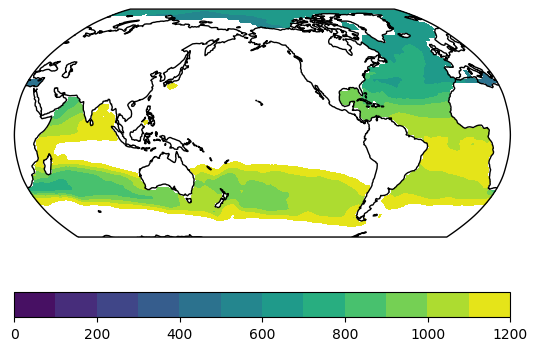

PyObject <matplotlib.colorbar.Colorbar object at 0x122290438>

In [22]:
using Conda; Conda.add("Cartopy")
#Conda.add("cartopy.crs")

ccrs = pyimport("cartopy.crs")
ax = subplot(projection=ccrs.Robinson(central_longitude=-155.0))
ax.coastlines()
# making it cyclic for Cartopy
lon_cyc = [lon; 360+lon[1]] 
age_cyc = hcat(c14age_3d_1000m_yr, c14age_3d_1000m_yr[:,1])
# And plot
p = contourf(lon_cyc, lat, age_cyc, levels=0:100:1200, transform=ccrs.PlateCarree(), zorder=-1)
colorbar(p, orientation="horizontal")